In [1]:
#imports
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import math
from sklearn.metrics import mean_squared_error
import random

#Graph settings
sns.set(style='ticks', font_scale=0.9)


row_dict=dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
                  ['OGI19-L','Ut14','Gh36','Og85','Og87','Og88','EC17','CB']))

col_dict_dict={1:dict(zip([1,2,3,4,5,6,7,8,9,10,11,12],
                          ['EC','EC','EC','RP','RP','RP',
                           'CF','CF','CF','EA','EA','EA',])), 
               2:dict(zip([1,2,3,4,5,6],
                          ['BI','BI','BI','PA','PA','PA',]))}

focal_mono_dict=dict(zip(['A', 'B', 'C', 'D', 'E', 'F'],['EC','RP','CF','EA','BI','PA']))

phylo=pd.read_excel('Data/Strains.xlsx')
phylo_dict=dict(zip(phylo['Sample Name'],phylo['Identifier']))

In [2]:
#Create Dataframes
file='Data/Splitwell_data.xlsx'
od_dict={}
gfp_dict={}

for i in ['1','2']:
    for ii in ['A','B']:
        od_dict[i+'_'+ii]=pd.read_excel(file, sheet_name='Plate'+i+'_Side_'+ii,
                                        skiprows=31, usecols="B:N",index_col=0).head(8)
        gfp_dict[i+'_'+ii]=pd.read_excel(file, sheet_name='Plate'+i+'_Side_'+ii,
                                        skiprows=44, usecols="B:N",index_col=0).head(8)
        
        
#Normalize
od_blank=od_dict['2_B'].loc[['G','H']][[10,11,12]].mean().mean()
gfp_blank=gfp_dict['2_B'].loc[['G','H']][[10,11,12]].mean().mean()

for i in ['1','2']:
    for ii in ['A','B']:
        od_dict[i+'_'+ii]=(od_dict[i+'_'+ii]-od_blank).clip(lower=0)
        gfp_dict[i+'_'+ii]=(gfp_dict[i+'_'+ii]-gfp_blank).clip(lower=0)

In [3]:
# median mono growth for each target
mono_dict_od={}
mono_dict_median_od={}
for row in ['A', 'B', 'C', 'D', 'E', 'F']:
    mono_dict_od[focal_mono_dict[row]]=list(od_dict['2_B'].loc[row][[10,11,12]])
    mono_dict_median_od[focal_mono_dict[row]]=od_dict['2_B'].loc[row][[10,11,12]].median()
    
#reorginize coculture data into single dataframe
reorg_df=pd.DataFrame(columns=['focal','affecting', 'co_od'])

for col in range (1,13):
    for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        temp_list=[]
        temp_list.append(col_dict_dict[1][col])
        temp_list.append(row_dict[row])
        temp_list.append(od_dict['1_B'].at[row,col])
        reorg_df.loc[len(reorg_df)]=temp_list
        
for col in range (1,7):
    for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        temp_list=[]
        temp_list.append(col_dict_dict[2][col])
        temp_list.append(row_dict[row])
        temp_list.append(od_dict['2_B'].at[row,col])
        reorg_df.loc[len(reorg_df)]=temp_list
        
#calculate ste via bootstapping
ste_df=pd.DataFrame(columns=['focal','affecting','od_STE'])
for i in reorg_df.focal.unique():
    for ii in reorg_df.affecting.unique():
        temp_data=reorg_df[(reorg_df.focal==i)&(reorg_df.affecting==ii)]
        bootstrap_list=[]
        for r in range(100):
            random.seed(r)
            bootstrap_mono=np.median(random.choices(mono_dict_od[i],k=3))
            bootstrap_list.append(np.log(((temp_data['co_od'].sample(3, replace=True, random_state=r))
                                             .median())/bootstrap_mono))
        iqr=sp.stats.iqr(bootstrap_list)
        ste_df.loc[len(ste_df)] = [i,ii,iqr]
        
effect_od=reorg_df.groupby(['focal','affecting']).median().reset_index()
effect_od['mono_od']=effect_od['focal'].map(mono_dict_median_od)
effect_od['od_effect']=np.log(effect_od['co_od']/effect_od['mono_od'])
effect_od=effect_od.merge(ste_df,on=['focal','affecting'])


<ipython-input-3-9f92b5464f43>:36: RuntimeWarning: divide by zero encountered in log
  bootstrap_list.append(np.log(((temp_data['co_od'].sample(3, replace=True, random_state=r))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [4]:
# median mono growth for each target
mono_dict_gfp={}
mono_dict_median_gfp={}
for row in ['A', 'B', 'C', 'D', 'E', 'F']:
    mono_dict_gfp[focal_mono_dict[row]]=list(gfp_dict['2_B'].loc[row][[10,11,12]])
    mono_dict_median_gfp[focal_mono_dict[row]]=gfp_dict['2_B'].loc[row][[10,11,12]].median()
    
#reorginize coculture data into single dataframe
reorg_gfp=pd.DataFrame(columns=['focal','affecting', 'co_gfp'])

for col in range (1,13):
    for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        temp_list=[]
        temp_list.append(col_dict_dict[1][col])
        temp_list.append(row_dict[row])
        temp_list.append(gfp_dict['1_B'].at[row,col])
        reorg_gfp.loc[len(reorg_gfp)]=temp_list
        
for col in range (1,7):
    for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        temp_list=[]
        temp_list.append(col_dict_dict[2][col])
        temp_list.append(row_dict[row])
        temp_list.append(gfp_dict['2_B'].at[row,col])
        reorg_gfp.loc[len(reorg_gfp)]=temp_list
        
#calculate ste via bootstapping
ste_df=pd.DataFrame(columns=['focal','affecting','gfp_STE'])
for i in reorg_gfp.focal.unique():
    for ii in reorg_gfp.affecting.unique():
        temp_data=reorg_gfp[(reorg_gfp.focal==i)&(reorg_gfp.affecting==ii)]
        bootstrap_list=[]
        for r in range(100):
            random.seed(r)
            bootstrap_mono=np.median(random.choices(mono_dict_gfp[i],k=3))
            bootstrap_list.append(np.log(((temp_data['co_gfp'].sample(3, replace=True, random_state=r))
                                             .median())/bootstrap_mono))
        iqr=sp.stats.iqr(bootstrap_list)
        ste_df.loc[len(ste_df)] = [i,ii,iqr]
        
effect_gfp=reorg_gfp.groupby(['focal','affecting']).median().reset_index()
effect_gfp['mono_gfp']=effect_gfp['focal'].map(mono_dict_median_gfp)
effect_gfp['gfp_effect']=np.log(effect_gfp['co_gfp']/effect_gfp['mono_gfp'])
effect_gfp=effect_gfp.merge(ste_df,on=['focal','affecting'])


<ipython-input-4-d8a943b81413>:36: RuntimeWarning: divide by zero encountered in log
  bootstrap_list.append(np.log(((temp_data['co_gfp'].sample(3, replace=True, random_state=r))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
<ipython-input-4-d8a943b81413>:36: RuntimeWarning: divide by zero encountered in log
  bootstrap_list.append(np.log(((temp_data['co_gfp'].sample(3, replace=True, random_state=r))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [5]:
#Merge GFP from both sides of the well and rerun analysis
gfp_p1=(gfp_dict['1_A']+gfp_dict['1_B'])
gfp_p2=(gfp_dict['2_A']+gfp_dict['2_B'])


#reorginize coculture data into single dataframe
reorg_df2=pd.DataFrame(columns=['focal','affecting', 'co_gfp'])

for col in range (1,13):
    for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        temp_list=[]
        temp_list.append(col_dict_dict[1][col])
        temp_list.append(row_dict[row])
        temp_list.append(gfp_p1.at[row,col])
        reorg_df2.loc[len(reorg_df2)]=temp_list
        
for col in range (1,7):
    for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        temp_list=[]
        temp_list.append(col_dict_dict[2][col])
        temp_list.append(row_dict[row])
        temp_list.append(gfp_p2.at[row,col])
        reorg_df2.loc[len(reorg_df2)]=temp_list
        
#calculate ste via bootstapping
ste_df=pd.DataFrame(columns=['focal','affecting','gfp_STE'])
for i in reorg_df2.focal.unique():
    for ii in reorg_df2.affecting.unique():
        temp_data=reorg_df2[(reorg_df2.focal==i)&(reorg_df2.affecting==ii)]
        bootstrap_list=[]
        for r in range(100):
            random.seed(r)
            bootstrap_mono=np.median(random.choices(mono_dict_gfp[i],k=3))
            bootstrap_list.append(np.log(((temp_data['co_gfp'].sample(3, replace=True, random_state=r))
                                             .median())/bootstrap_mono))
        iqr=sp.stats.iqr(bootstrap_list)
        ste_df.loc[len(ste_df)] = [i,ii,iqr]
        
gfp_both=reorg_df2.groupby(['focal','affecting']).median().reset_index()
gfp_both['mono_gfp']=gfp_both['focal'].map(mono_dict_median_gfp)
gfp_both['gfp_effect']=np.log(gfp_both['co_gfp']/gfp_both['mono_gfp'])
gfp_both=gfp_both.merge(ste_df,on=['focal','affecting'])


In [6]:
effect_df=effect_od.merge(gfp_both,on=['focal','affecting'])

#Filtering out to speices not used in the final datasets of the chip experiments
effect_df=effect_df[(effect_df.affecting!='Og88')&(effect_df.affecting!='Og85')]

LinregressResult(slope=0.6014909287171599, intercept=0.4447616233241462, rvalue=0.7111885094210698, pvalue=1.1652450011313525e-06, stderr=0.10196733150432653, intercept_stderr=0.14884214093855364)


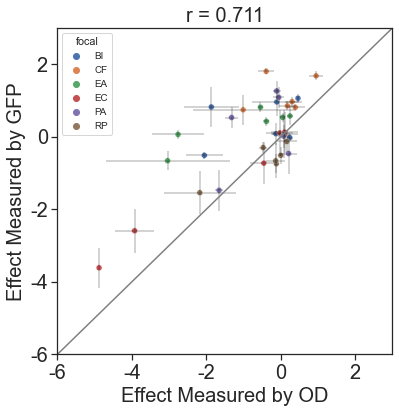

In [7]:
r=(sp.stats.linregress(list(effect_df['od_effect']),list(effect_df['gfp_effect'])))
rmse=(mean_squared_error(effect_df['od_effect'], effect_df['gfp_effect']))**0.5

fig, axes = plt.subplots(1, 1,  figsize=(6, 6))

g=sns.scatterplot(data=effect_df,x='od_effect',y='gfp_effect', hue='focal')
g.add_line(mlines.Line2D([range(-7,4)],[range(-7,4)], color='gray'))

g.errorbar(effect_df.od_effect,effect_df.gfp_effect,
           xerr=effect_df.od_STE,yerr=effect_df.gfp_STE,
           fmt=" ", c="k", alpha=0.25)


g.set_ylim (-6,3)
g.set_xlim (-6,3)

g.set_xticks([-6,-4,-2,0,2])
g.set_xticklabels([-6,-4,-2,0,2], fontsize = 20)

g.set_yticks([-6,-4,-2,0,2])
g.set_yticklabels([-6,-4,-2,0,2], fontsize = 20)

g.set_xlabel("Effect Measured by OD", fontsize = 20)
g.set_ylabel("Effect Measured by GFP", fontsize = 20)
g.set_title('r = '+str(r[2].round(3)),fontsize = 20)
print (r)
fig.savefig('gfp_od_corr.png',dpi=300, bbox_inches='tight')

In [8]:
chip_effects=(pd.read_csv('k2_effects_data.csv').drop(columns=['Unnamed: 0']))
chip_effects=chip_effects[chip_effects.sample1==chip_effects.sample2]
chip_effects=chip_effects[['focal','sample1','mono_s1_effect','STE']]
chip_effects=chip_effects.rename(columns={'sample1':'affecting',
                                          'mono_s1_effect':'chip_effect',
                                          'STE':'chip_STE'})
chip_effects=chip_effects.replace({'RP1':'RP','PAg':'PA'})
effect_df=effect_df.merge(chip_effects, on=['focal','affecting'], how='inner')

LinregressResult(slope=0.7073976593071482, intercept=0.196739932270089, rvalue=0.5487853983315882, pvalue=0.0011444627710121876, stderr=0.19673772227443387, intercept_stderr=0.1834564488520108)


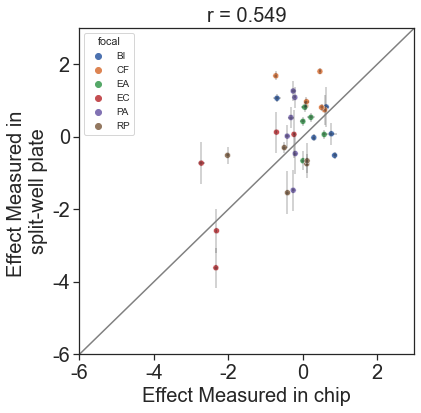

In [9]:
r=(sp.stats.linregress(list(effect_df['chip_effect']),list(effect_df['gfp_effect'])))
rmse=(mean_squared_error(effect_df['chip_effect'], effect_df['gfp_effect']))**0.5

fig, axes = plt.subplots(1, 1,  figsize=(6,6))

g=sns.scatterplot(data=effect_df,x='chip_effect',y='gfp_effect', hue='focal')
g.add_line(mlines.Line2D([range(-7,4)],[range(-7,4)], color='gray'))

g.errorbar(effect_df.chip_effect,effect_df.gfp_effect,
           xerr=effect_df.chip_STE,yerr=effect_df.gfp_STE,
           fmt=" ", c="k", alpha=0.25)


g.set_ylim (-6,3)
g.set_xlim (-6,3)

g.set_xticks([-6,-4,-2,0,2])
g.set_xticklabels([-6,-4,-2,0,2], fontsize = 20)

g.set_yticks([-6,-4,-2,0,2])
g.set_yticklabels([-6,-4,-2,0,2], fontsize = 20)

g.set_xlabel("Effect Measured in chip", fontsize = 20)
g.set_ylabel("Effect Measured in \nsplit-well plate", fontsize = 20)
g.set_title('r = '+str(r[2].round(3)),fontsize = 20)
print (r)
fig.savefig('chip_plate_corr.png',dpi=300, bbox_inches='tight')